# This is to prepare the clustering measurement by setting up the files

1) First prepare the config file\
2) prepare the command script with given selections\
3) submit the command on compute node\
4) looks at the results\


In [2]:
from __future__ import print_function
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

import pickle
import numpy as np
import pylab as pl
import fitsio as F
import time

from datetime import date

import os

# create the necessary config files

In [55]:
def tracer_program(tracer):
    if('BGS' in tracer or 'MWS' in tracer):
        return 'BRIGHT'
    else:
        return 'DARK'
    

def zsel_tracer(tracer1,tracer2=None):
    '''some predefined redshift selection used for 3d clustering'''
    
    zsel_dic={'BGS':[[0.1,0.5],[0.1,0.3],[0.2,0.4]],
              'LRG':[[0.6,1.05],[0.32,0.6],[0.6,0.8],[0.8,1.05]],
              'ELG':[[0.8,1.6],[0.6,0.8],[0.8,1.05],[1.05,1.3],[1.3,1.6]],
              'QSO':[[0.8,2.1],[0.6,0.8],[0.8,1.05],[1.05,1.30],[1.3,1.6],[1.6,2.1]]}
    
    zout=[None]
    
 
    if(tracer2 is not None):  
        priority=['BGS','LRG','ELG','QSO']
        for pri in priority:
            if(tracer1 in pri or tracer2 in pri):
                zout=zsel_dic[pri]
                break  
    else:
        for tkey in zsel_dic:
            if(tkey in tracer):
                zout=zsel_dic[tkey]
                break  
    return zout

    
def config_file(config_dir,tracer,sky,xitype,wtag,zsel,tracer2=None):
    if(zsel is not None):
        ztag='_z1z2_%4.2f_%4.2f'%(zsel[0],zsel[1])
    else:
        ztag=''
    
    if(tracer2 is None):
        outfile='%s%s_%s_%s_%s%s.ini'%(config_dir,tracer,sky,xitype,wtag,ztag)
    else:
        outfile='%scross%sx%s_%s_%s_%s%s.ini'%(config_dir,tracer,tracer2,sky,xitype,wtag,ztag)
    
    return outfile

def prepare_config_file(tracer,sky,wtag='w1',xitype='angular',zsel=None,config_dir='config_desi_sv3/',
                       tracer2=None):
    
    '''prepares the configuration files
    provide tracer 2 and wtag2 if cross-correlation is needed'''
    
    if(zsel is not None):
        zsel_str='z1z2 = %4.2f, %4.2f'%(zsel[0],zsel[1])
    else:
        zsel_str=''
    
    outfile=config_file(config_dir,tracer,sky,xitype,wtag,zsel,tracer2=tracer2)
    
    program=tracer_program(tracer)
    with open(outfile,'w') as fout:
        if(tracer2 is None):
            fout.write('import_config1 = config_desi_glob/%s_global.ini\n'%xitype)
        else:
            fout.write('import_config1 = config_desi_glob/cross%s_global.ini\n'%xitype)
        
        fout.write('import_config2 = config_desi_glob/%s_catalog.ini\n'%program)

        fout.write(zsel_str)
            

        fout.write('\n\n#parameters for the this catalogue\n')
        fout.write('[sv3_desi]\n')
        fout.write('PROGRAM = %s\n'%program)
        fout.write('tracer = %s\n'%tracer)
        fout.write('sky = %s\n'%sky)
        fout.write('#This decides the weighting w1 is unit weight wsys is sys weight\n')
        fout.write('wtag = %s\n'%wtag)
        
        if(tracer2 is not None):
            fout.write('\n\n#parameters for the second catalogue\n')
            fout.write('[sv3_desi2]\n')
            fout.write('PROGRAM = %s\n'%program)
            fout.write('tracer = %s\n'%tracer2)
            fout.write('sky = %s\n'%sky)
            fout.write('#This decides the weighting w1 is unit weight wsys is sys weight\n')
            fout.write('wtag = %s\n'%wtag)   
               
    return outfile

def scan_tracer(auto=True,cross=False):
    use_tracer=[]
    if(auto):#load from file
        tracer_file='/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test_Shadab/tracers_list.txt'
        tlines=open(tracer_file,'r').readlines()
        for tt,tline in enumerate(tlines):
            tspl=tline.split()
            if(tspl[0] not in use_tracer):
                use_tracer.append(tspl[0])
                
    if(cross):
        cross_list=[['LRG','ELG'],['ELG','QSO'],['LRG','QSO']]
        use_tracer=use_tracer+cross_list
                
    return use_tracer

def tracer_key(tracer):
    '''gives the tracer key'''
    if(isinstance(tracer,list)):
        tracer1=tracer[0]
        tracer2=tracer[1]
        tkey='cross-%sx%s'%(tracer1,tracer2)
    else:
        tkey=tracer
        
    return tkey


def prepare_tracers_comm(wtag='w1',xitype='angular',skip=[],use_tracer=[],
            sky_list=['N','S'],config_dir='config_desi_sv3/',auto=True,cross=False):
    
    if(use_tracer==[]):#load from file
        use_tracer=scan_tracer(auto=auto,cross=cross)
            
    conf_file=[]
    for tt, tracer in enumerate(use_tracer):
        if(isinstance(tracer,list)):
            tracer1=tracer[0]
            tracer2=tracer[1]
        else:
            tracer1=tracer
            tracer2=None
        
        if(xitype=='wp'):
            zsel_list=zsel_tracer(tracer1,tracer2=tracer2)
        else:
            zsel_list=[None]
            
            

        for ss,sky in enumerate(sky_list):
            for zsel in zsel_list:
                tconf=prepare_config_file(tracer1,sky,wtag=wtag,xitype=xitype,zsel=zsel,config_dir=config_dir,tracer2=tracer2)
                conf_file.append(tconf)
            
    return conf_file


#Generate the config files

config_dir='config_desi_sv3_tmp/'
xitype_list=['angular','wp']
auto=False;cross=True;
wtag_dic={'angular':['w1','wcomp'],'wp':['w1','wcomp']}

#wtag='w1'  #unit weight for everything
#wtag='wcomp' #completness weight for both data and random
#wtag='wcompR1' #only completeness weight for data but not randoms

#tracer='LRG';sky='N'
#prepare_config_file(tracer,sky,wtag='w1',xitype='angular',config_dir='CorrelationFunction/config_desi_sv3/')

conf_dic={}
for xitype in xitype_list:
    conf_dic[xitype]={}
    for wtag in wtag_dic[xitype]:
        conf_dic[xitype][wtag]=prepare_tracers_comm(wtag=wtag,xitype=xitype,skip=[],use_tracer=[],config_dir=config_dir,
                                                   auto=auto,cross=cross)
        
print(conf_dic)

print('done')


{'angular': {'w1': ['config_desi_sv3_tmp/crossLRGxELG_N_angular_w1.ini', 'config_desi_sv3_tmp/crossLRGxELG_S_angular_w1.ini', 'config_desi_sv3_tmp/crossELGxQSO_N_angular_w1.ini', 'config_desi_sv3_tmp/crossELGxQSO_S_angular_w1.ini', 'config_desi_sv3_tmp/crossLRGxQSO_N_angular_w1.ini', 'config_desi_sv3_tmp/crossLRGxQSO_S_angular_w1.ini'], 'wcomp': ['config_desi_sv3_tmp/crossLRGxELG_N_angular_wcomp.ini', 'config_desi_sv3_tmp/crossLRGxELG_S_angular_wcomp.ini', 'config_desi_sv3_tmp/crossELGxQSO_N_angular_wcomp.ini', 'config_desi_sv3_tmp/crossELGxQSO_S_angular_wcomp.ini', 'config_desi_sv3_tmp/crossLRGxQSO_N_angular_wcomp.ini', 'config_desi_sv3_tmp/crossLRGxQSO_S_angular_wcomp.ini']}, 'wp': {'w1': ['config_desi_sv3_tmp/crossLRGxELG_N_wp_w1_z1z2_0.60_1.05.ini', 'config_desi_sv3_tmp/crossLRGxELG_N_wp_w1_z1z2_0.32_0.60.ini', 'config_desi_sv3_tmp/crossLRGxELG_N_wp_w1_z1z2_0.60_0.80.ini', 'config_desi_sv3_tmp/crossLRGxELG_N_wp_w1_z1z2_0.80_1.05.ini', 'config_desi_sv3_tmp/crossLRGxELG_S_wp_w1_z1z2_

# Generate the command to execute with appropriate selections
selection = TARGET uses target sample\
selection = CLUSTERING uses clustering sample this can use completenes weight if in the prvious step wtag was set to wcomp

use following to request a node before running these:\
salloc -N 1 -C haswell -t 00:30:00 --ntasks 1 --cpus-per-task=4 --qos shared --account desi

In [57]:
def get_outroot(selection='TARGET',tracer='LRG',sky='N',wtag='w1',xitype='angular'):
    pcdir='/global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/'
    
    if(xitype=='angular'):
        outroot='%s%s_%s_%s_%s'%(pcdir,tracer_key(tracer),sky,selection,wtag)
    else:
        outroot='%s%s_%s_%s_%s_z1z2_'%(pcdir,tracer_key(tracer),sky,selection,wtag)
        
    return outroot

def get_ang_up_weight(wtag='w1',sky_list=['N','S'],auto=True,cross=False):
    use_tracer=scan_tracer(auto=auto,cross=cross)
    comm=[]
    for tt,tracer in enumerate(use_tracer):
        for ss,sky in enumerate(sky_list):
            parent_root=get_outroot(selection='TARGET',tracer=tracer,sky=sky,wtag='w1')
            fiber_root=get_outroot(selection='CLUSTERING',tracer=tracer,sky=sky,wtag=wtag)

            tcomm='python compute_angular_upweight.py -parent_root %s -fiber_root %s'%(parent_root,fiber_root)
            
            comm.append(tcomm)
            
    return comm

def slurm_script_shared(outfile,comm,ncpu=4,time=None):
    with open(outfile,'w') as fout:
        fout.write('#!/bin/bash\n')
        fout.write('#SBATCH --qos=shared\n')
        fout.write('#SBATCH --constraint=haswell\n')
        if(time is None):
            time='01:00:00'
            
        fout.write('#SBATCH --time=%s\n'%time)
        
        fout.write('#SBATCH --nodes=1\n')
        fout.write('#SBATCH --ntasks=1\n')
        fout.write('#SBATCH --cpus-per-task=%s\n'%ncpu)
        
        fout.write('\nsource /project/projectdirs/desi/software/desi_environment.sh master \n')
        
        for tcomm in comm:
            fout.write('srun --cpu-bind=cores %s \n'%tcomm)
        
    print('sbatch %s'%outfile)
    
    return

def get_pc_case(xitype):
    if(xitype=='angular'):
        pc_case={'case1':{'wtag':'w1','add_comm':'-selection TARGET','get_angup':False},
             'case2':{'wtag':'w1','add_comm':'-selection CLUSTERING','get_angup':True},
             'case3':{'wtag':'wcomp','add_comm':'-selection CLUSTERING','get_angup':True},
            'case4':{'wtag':'wcomp','add_comm':'-selection CLUSTERING -ang_up True -nocheck_pairnorm True','get_angup':False}
            }

    elif(xitype=='wp'):
        pc_case={'case1':{'wtag':'w1','add_comm':'-selection CLUSTERING','get_angup':False},
             'case2':{'wtag':'wcomp','add_comm':'-selection CLUSTERING','get_angup':False},
            'case3':{'wtag':'wcomp','add_comm':'-selection CLUSTERING -ang_up True -nocheck_pairnorm True','get_angup':False},
            }
    return pc_case


slurm=False
xitype='angular'
#xitype='wp'

pc_case=get_pc_case(xitype)

comm=[]
for case in range(1,len(pc_case.keys())+1):
    #if(case!=4):
    #    continue
        #print('****** \n Please make sure all the previous case is already done as this needs angular upweight\n\n***\n')
        
    wtag=pc_case['case%d'%case]['wtag']
    add_comm=pc_case['case%d'%case]['add_comm']
    get_angup=pc_case['case%d'%case]['get_angup']
    
    conf_file=conf_dic[xitype][wtag]
    
    
    for cc in conf_file:
        tcomm='python Runme_Correlation.py -config_file %s %s'%(cc,add_comm)

        comm.append(tcomm)
        
    if(get_angup): #compute angular upweight
        tcomm=get_ang_up_weight(wtag=wtag,sky_list=['N','S'],auto=auto,cross=cross)
        comm=comm+tcomm

    
if(slurm):
    outfile='tmp_shared_%s.sh'%(xitype)
    slurm_script_shared(outfile,comm,ncpu=4,time='10:00:00')
else:
    for tcomm in comm:
        print(tcomm)

python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossLRGxELG_N_angular_w1.ini -selection TARGET
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossLRGxELG_S_angular_w1.ini -selection TARGET
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossELGxQSO_N_angular_w1.ini -selection TARGET
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossELGxQSO_S_angular_w1.ini -selection TARGET
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossLRGxQSO_N_angular_w1.ini -selection TARGET
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossLRGxQSO_S_angular_w1.ini -selection TARGET
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossLRGxELG_N_angular_w1.ini -selection CLUSTERING
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossLRGxELG_S_angular_w1.ini -selection CLUSTERING
python Runme_Correlation.py -config_file config_desi_sv3_tmp/crossELGxQSO_N_angular_w1.ini -selection CLUSTERING
python 

In [19]:
conf_dic[xitype]

{'wcomp': ['config_desi_sv3_tmp/BGS_ANY_N_wp_wcomp_z1z2_0.10_0.50.ini',
  'config_desi_sv3_tmp/BGS_ANY_N_wp_wcomp_z1z2_0.10_0.30.ini',
  'config_desi_sv3_tmp/BGS_ANY_N_wp_wcomp_z1z2_0.20_0.40.ini',
  'config_desi_sv3_tmp/BGS_ANY_S_wp_wcomp_z1z2_0.10_0.50.ini',
  'config_desi_sv3_tmp/BGS_ANY_S_wp_wcomp_z1z2_0.10_0.30.ini',
  'config_desi_sv3_tmp/BGS_ANY_S_wp_wcomp_z1z2_0.20_0.40.ini',
  'config_desi_sv3_tmp/ELG_N_wp_wcomp_z1z2_0.80_1.60.ini',
  'config_desi_sv3_tmp/ELG_N_wp_wcomp_z1z2_0.60_0.80.ini',
  'config_desi_sv3_tmp/ELG_N_wp_wcomp_z1z2_0.80_1.05.ini',
  'config_desi_sv3_tmp/ELG_N_wp_wcomp_z1z2_1.05_1.30.ini',
  'config_desi_sv3_tmp/ELG_N_wp_wcomp_z1z2_1.30_1.60.ini',
  'config_desi_sv3_tmp/ELG_S_wp_wcomp_z1z2_0.80_1.60.ini',
  'config_desi_sv3_tmp/ELG_S_wp_wcomp_z1z2_0.60_0.80.ini',
  'config_desi_sv3_tmp/ELG_S_wp_wcomp_z1z2_0.80_1.05.ini',
  'config_desi_sv3_tmp/ELG_S_wp_wcomp_z1z2_1.05_1.30.ini',
  'config_desi_sv3_tmp/ELG_S_wp_wcomp_z1z2_1.30_1.60.ini',
  'config_desi_sv3_tmp/

# Compute the angular upweights

python compute_angular_upweight.py -parent_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/BGS_ANY_N_TARGET_w1 -fiber_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/BGS_ANY_N_CLUSTERING_wcomp
python compute_angular_upweight.py -parent_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/BGS_ANY_S_TARGET_w1 -fiber_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/BGS_ANY_S_CLUSTERING_wcomp
python compute_angular_upweight.py -parent_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/ELG_N_TARGET_w1 -fiber_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/ELG_N_CLUSTERING_wcomp
python compute_angular_upweight.py -parent_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/ELG_S_TARGET_w1 -fiber_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/ELG_S_CLUSTERING_wcomp
python compute_angular_upweight.py -parent_root /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/ELG_HIP_N_TARGET_w1 -fiber_root /global/cfs/cdirs/desi

# plot angular upweights

No handles with labels found to put in legend.
No handles with labels found to put in legend.


miss:  CLUSTERING cross-LRGxELG NS
miss:  CLUSTERING cross-ELGxQSO N
miss:  CLUSTERING cross-ELGxQSO S
miss:  CLUSTERING cross-ELGxQSO NS
miss:  CLUSTERING cross-LRGxQSO N
miss:  CLUSTERING cross-LRGxQSO S
miss:  CLUSTERING cross-LRGxQSO NS


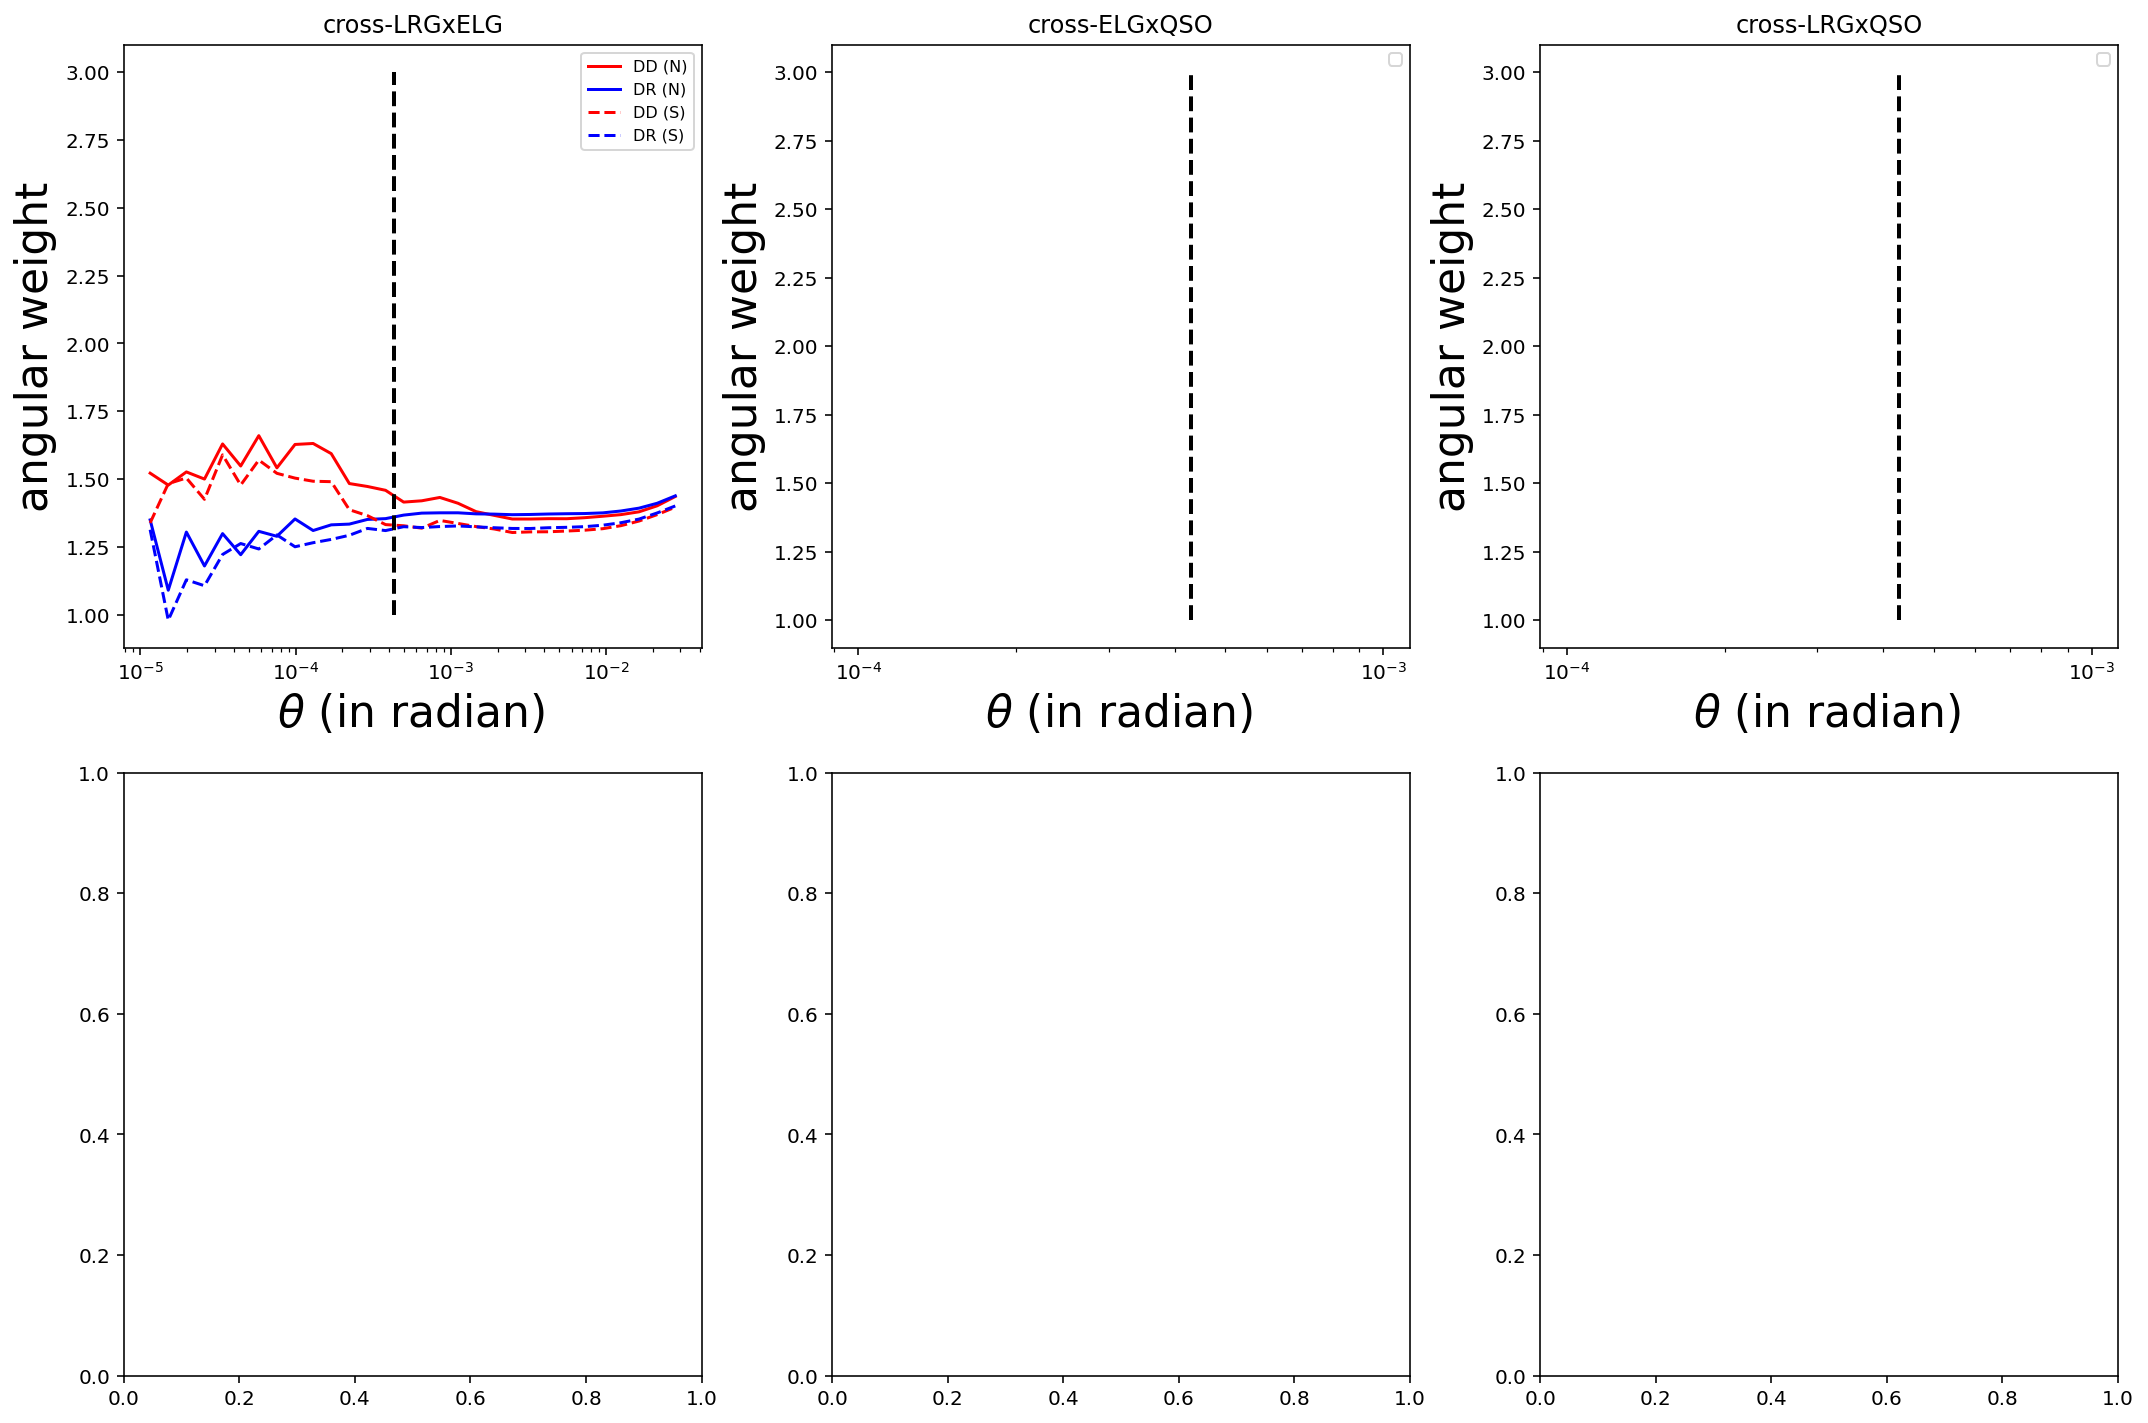

In [63]:
def load_wang_up(axarr,selection='CLUSTERING',use_tracer=[],wtag_fiber='w1',auto=True,cross=False):
    if(use_tracer==[]):
        use_tracer=scan_tracer(auto=auto,cross=cross)
        
    tmarks=['-','--']
    tcols=['r','b']
    outdir='/global/cfs/cdirs/desi/users/shadaba/sv3/XI/'
    wangup_dir=outdir+'wang_up/'
    
    njn_sky={'N':48,'S':48,'NS':96}

    use_tracer_key=[]
    for tracer in use_tracer:
        use_tracer_key.append(tracer_key(tracer))
        
    wang_dic={}
    for tt,tracer in enumerate(use_tracer_key):
        pl.sca(axarr[tt])
        wang_dic[tracer]={}
        for ss,sky in enumerate(['N','S','NS']):
            wangup_file='%s%s_%s_%s_%s_wang.txt'%(wangup_dir,tracer,sky,selection,wtag_fiber)
            try:
                wang_dic[tracer][sky]=np.loadtxt(wangup_file)
            except:
                print('miss: ',selection,tracer,sky)
                continue
                
            txi=wang_dic[tracer][sky]
            
            if(sky=='N'):
                tlab='%s %s %s'%(selection,sky,wtag)
            else:
                tlab=sky
                
            tlab_DD='DD (%s)'%(sky)
            pl.plot(txi[:,0],txi[:,3],tmarks[ss],color=tcols[0],label=tlab_DD)
            tlab_DR='DR (%s)'%(sky)
            pl.plot(txi[:,0],txi[:,4],tmarks[ss],color=tcols[1],label=tlab_DR)
           
        pl.title(tracer)
        pl.legend(fontsize=8)
        pl.xscale('log')
        #pl.yscale('log')
        
        pl.xlabel(r'$\theta$ (in radian) ',fontsize=22)
        pl.ylabel(r'angular weight',fontsize=22)
        
        pl.plot([4.3e-4,4.3e-4],[1,3],'k--',lw=2)
        
    #/global/cfs/cdirs/desi/users/shadaba/sv3/XI/Wtheta/ELG_N_TARGET_w1-wtheta_DP-logangular-NJN-48.txt
    return

use_tracer=scan_tracer()
ntracer=len(use_tracer)

ncol=3
nrow=np.int(np.ceil(ntracer/ncol))
                
figwidth=15;figheight=5
ncol=3;nrow=2
fig,axarr=pl.subplots(nrow,ncol,sharex=False,sharey=False,figsize=(figwidth,nrow*figheight))
axarr=axarr.reshape(axarr.size)

load_wang_up(axarr,use_tracer=[],wtag_fiber='wcomp',auto=auto,cross=cross)
#load_wang_up(axarr,use_tracer=[],wtag_fiber='w1')

pl.tight_layout()

pl.savefig('../plots/wang_weight_wcomp.png')


# Combine the north south pair count

In [65]:

xitype='angular'
pc_case=get_pc_case(xitype)

use_tracer=scan_tracer(auto=auto,cross=cross)
#print(pc_case)

for tt,tracer in enumerate(use_tracer):
    if(xitype=='wp'):
        zsel_list=zsel_tracer(tracer)
    else:
        zsel_list=[None]
        
    if(isinstance(tracer,list)):
        tracer1=tracer[0]
        tracer2=tracer[1]
    else:
        tracer1=tracer
        tracer2=None    
        
    for zsel in zsel_list:
        for cc,case in enumerate(pc_case.keys()):
            wtag=pc_case[case]['wtag']
            add_comm=pc_case[case]['add_comm']
            Nconf=config_file(config_dir,tracer1,'N',xitype,wtag,zsel,tracer2=tracer2)
            Sconf=config_file(config_dir,tracer1,'S',xitype,wtag,zsel,tracer2=tracer2)

            comm='python PairCountTOxi.py -config_file %s %s %s'%(Nconf,Sconf,add_comm)
            print(comm)

python PairCountTOxi.py -config_file config_desi_sv3_tmp/crossLRGxELG_N_angular_w1.ini config_desi_sv3_tmp/crossLRGxELG_S_angular_w1.ini -selection TARGET
python PairCountTOxi.py -config_file config_desi_sv3_tmp/crossLRGxELG_N_angular_w1.ini config_desi_sv3_tmp/crossLRGxELG_S_angular_w1.ini -selection CLUSTERING
python PairCountTOxi.py -config_file config_desi_sv3_tmp/crossLRGxELG_N_angular_wcomp.ini config_desi_sv3_tmp/crossLRGxELG_S_angular_wcomp.ini -selection CLUSTERING
python PairCountTOxi.py -config_file config_desi_sv3_tmp/crossLRGxELG_N_angular_wcomp.ini config_desi_sv3_tmp/crossLRGxELG_S_angular_wcomp.ini -selection CLUSTERING -ang_up True -nocheck_pairnorm True
python PairCountTOxi.py -config_file config_desi_sv3_tmp/crossELGxQSO_N_angular_w1.ini config_desi_sv3_tmp/crossELGxQSO_S_angular_w1.ini -selection TARGET
python PairCountTOxi.py -config_file config_desi_sv3_tmp/crossELGxQSO_N_angular_w1.ini config_desi_sv3_tmp/crossELGxQSO_S_angular_w1.ini -selection CLUSTERING
python

In [18]:
xitype

'wp'

No handles with labels found to put in legend.


3
miss:  TARGET cross-ELGxQSO S
miss:  TARGET cross-ELGxQSO NS
miss:  TARGET cross-LRGxQSO N
miss:  TARGET cross-LRGxQSO S
miss:  TARGET cross-LRGxQSO NS
miss:  CLUSTERING cross-LRGxELG N
miss:  CLUSTERING cross-LRGxELG S
miss:  CLUSTERING cross-LRGxELG NS
miss:  CLUSTERING cross-ELGxQSO NS
miss:  CLUSTERING cross-LRGxQSO NS
miss:  CLUSTERING cross-LRGxELG NS
miss:  CLUSTERING cross-ELGxQSO N
miss:  CLUSTERING cross-ELGxQSO S
miss:  CLUSTERING cross-ELGxQSO NS
miss:  CLUSTERING cross-LRGxQSO N
miss:  CLUSTERING cross-LRGxQSO S
miss:  CLUSTERING cross-LRGxQSO NS
miss:  CLUSTERING cross-LRGxELG N
miss:  CLUSTERING cross-LRGxELG S
miss:  CLUSTERING cross-LRGxELG NS
miss:  CLUSTERING cross-ELGxQSO N
miss:  CLUSTERING cross-ELGxQSO S
miss:  CLUSTERING cross-ELGxQSO NS
miss:  CLUSTERING cross-LRGxQSO N
miss:  CLUSTERING cross-LRGxQSO S
miss:  CLUSTERING cross-LRGxQSO NS


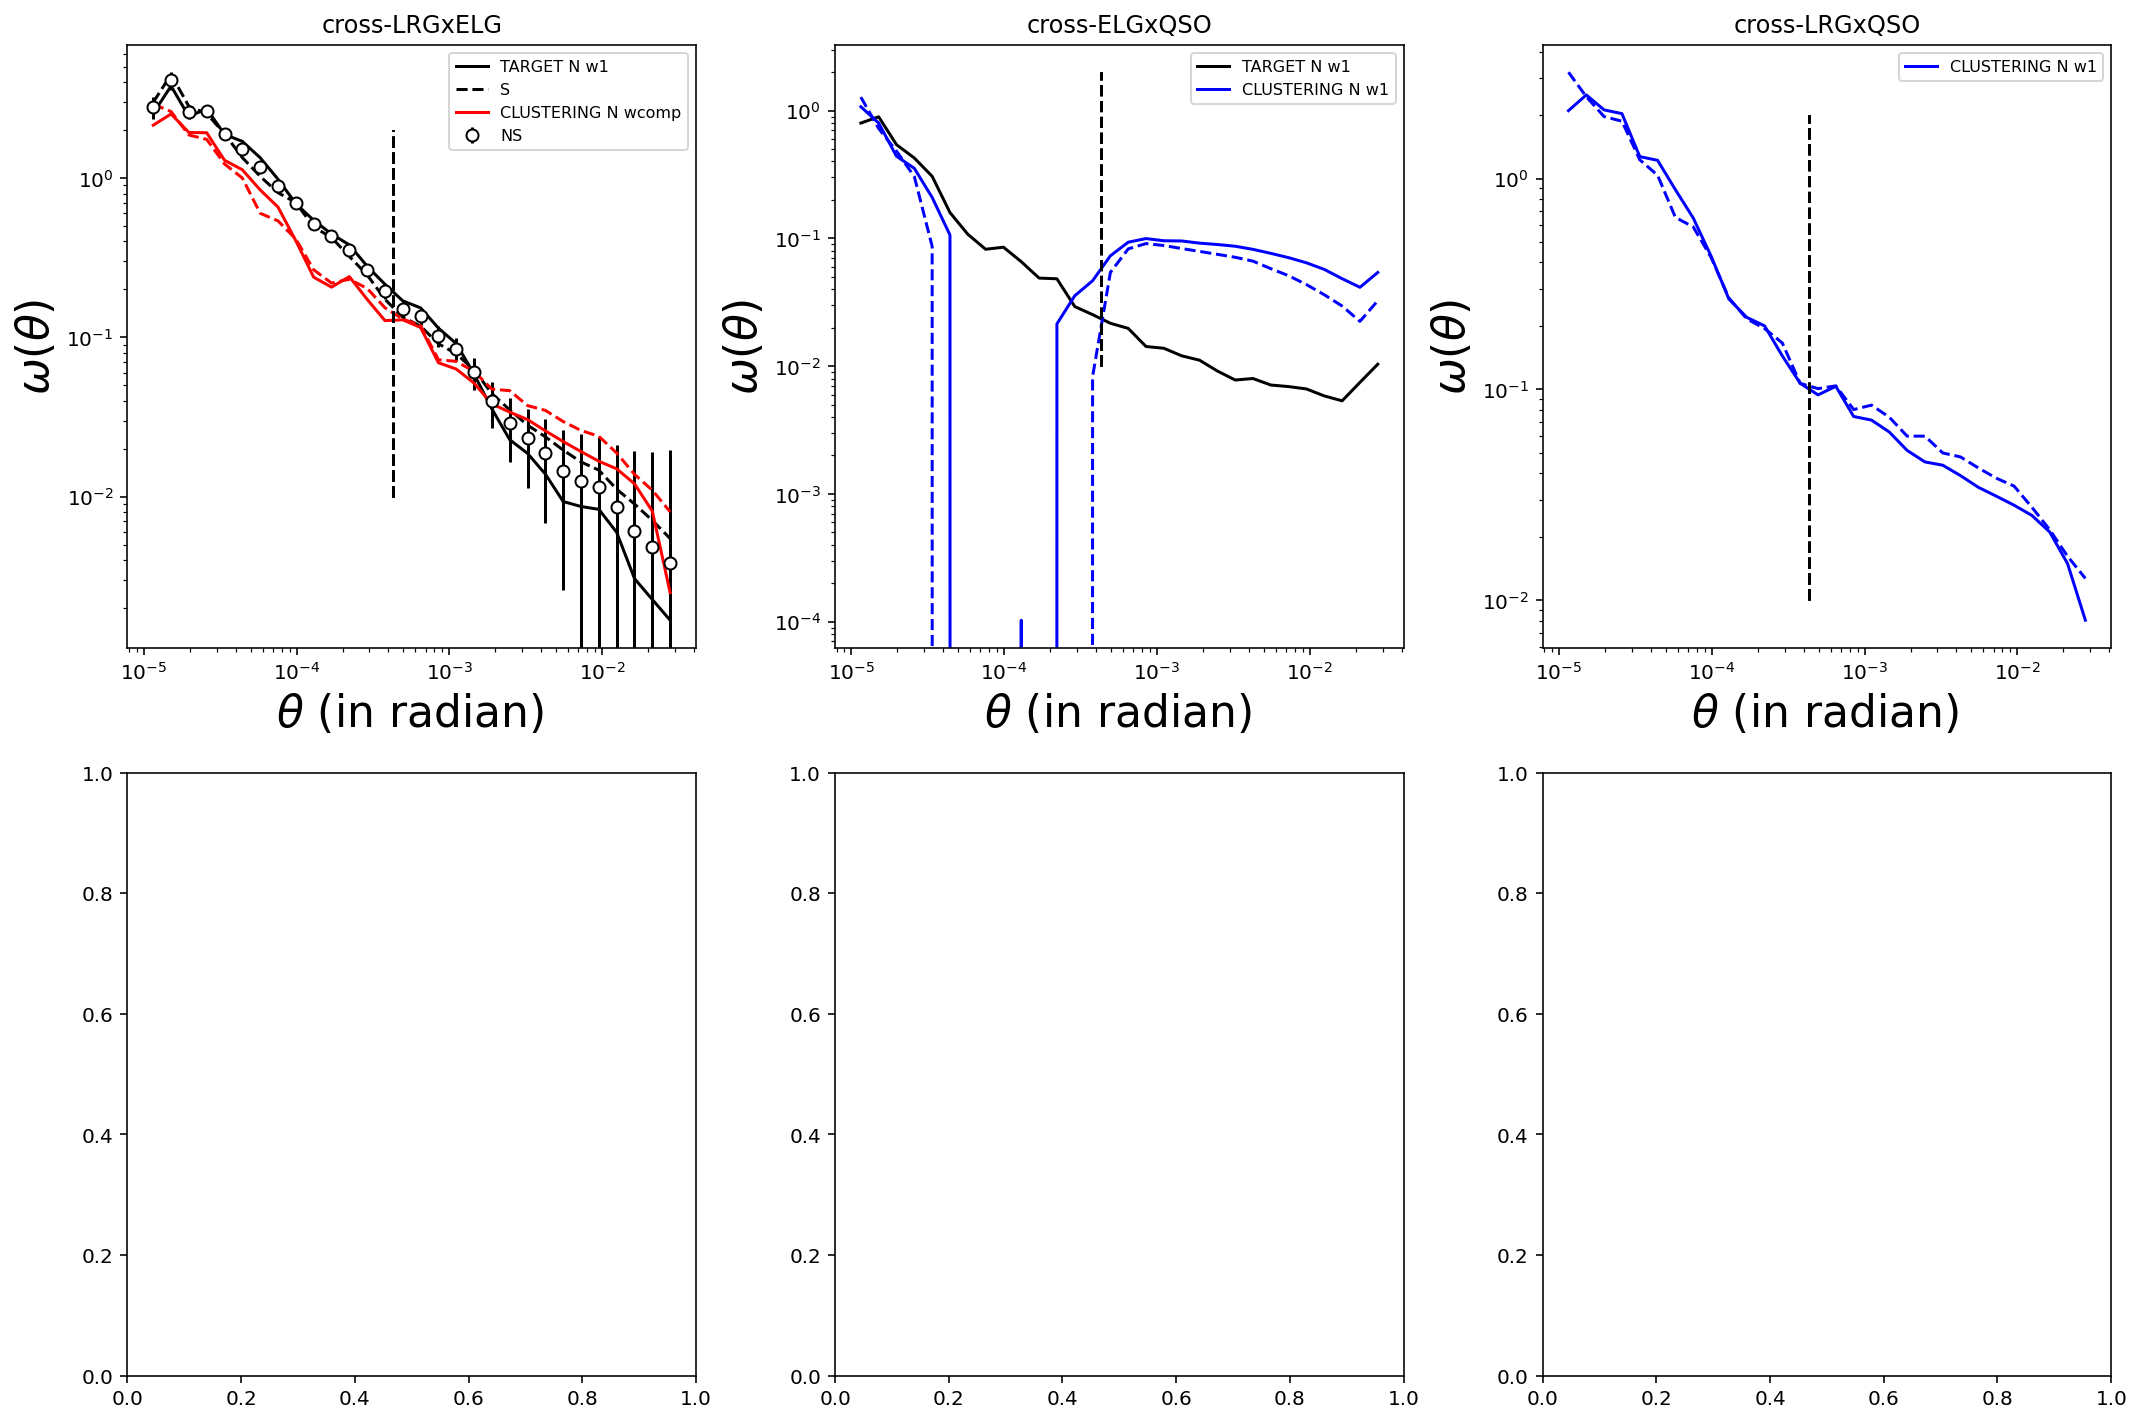

In [70]:
def load_xi(axarr,selection='TARGET',use_tracer=[],wtag='w1',xitype='angular',colin='r',pip=False,iip=False,ang_up=False):
    if(use_tracer==[]):
        use_tracer=scan_tracer()
        
    use_tracer_key=[]
    for tracer in use_tracer:
        use_tracer_key.append(tracer_key(tracer))    
        
    tmarks=['-','--']
    outdir='/global/cfs/cdirs/desi/users/shadaba/sv3/XI/'
    njn_sky={'N':48,'S':48,'NS':96}
    if(xitype=='angular'):
        xidir=outdir+'Wtheta/'
        ext='wtheta_DP-logangular'
        xlab=r'$\theta$ (in radian) '
        ylab=r'$\omega (\theta) $'
    elif(xitype=='wp'):
        xidir=outdir+'WP/'
        ext='wp-logrp-pi'
        xlab=r'$r_{\perp}$ (in Mpc/h) '
        ylab=r'$w_p$'
        
    pair_tag=''
    if(pip):
        pair_tag=pair_tag+'_pip'
    if(iip):
        pair_tag=pair_tag+'_iip'
    if(ang_up):
        pair_tag=pair_tag+'_angup'
        
    xidic={}
    for tt,tracer in enumerate(use_tracer_key):
        pl.sca(axarr[tt])
        xidic[tracer]={}
        for ss,sky in enumerate(['N','S','NS']):
            xifile='%s%s_%s_%s_%s%s-%s-NJN-%d.txt'%(xidir,tracer,sky,selection,wtag,pair_tag,ext,njn_sky[sky])
            try:
                xidic[tracer][sky]=np.loadtxt(xifile)
            except:
                print('miss: ',selection,tracer,sky)
                #print(xifile)
                continue
                
            txi=xidic[tracer][sky]
            
            if(sky=='N'):
                tlab='%s %s %s%s'%(selection,sky,wtag,pair_tag)
            elif(selection=='TARGET' and xitype=='angular'):
                tlab=sky
            elif(xitype!='angular' and ang_up):
                tlab=sky
            else:
                tlab=None
                
            if(sky!='NS'):
                pl.plot(txi[:,0],txi[:,3],tmarks[ss],color=colin,label=tlab)
            else:
                pl.errorbar(txi[:,0],txi[:,3],yerr=txi[:,2],fmt='o',mfc='w',color=colin,label=tlab)
                
        pl.title(tracer)
        pl.legend(fontsize=8)
        pl.xscale('log')
        pl.yscale('log')
        
        pl.xlabel(xlab,fontsize=22)
        pl.ylabel(ylab,fontsize=22)
        
        if(xitype=='angular'):
            pl.plot([4.3e-4,4.3e-4],[1e-2,2],'k--')
        
    #/global/cfs/cdirs/desi/users/shadaba/sv3/XI/Wtheta/ELG_N_TARGET_w1-wtheta_DP-logangular-NJN-48.txt
    return

use_tracer=scan_tracer(auto=auto,cross=cross)
ntracer=len(use_tracer)
print(ntracer)

ncol=3
nrow=np.int(np.ceil(ntracer/ncol))
                
figwidth=15;figheight=5
ncol=3;nrow=2
fig,axarr=pl.subplots(nrow,ncol,sharex=False,sharey=False,figsize=(figwidth,nrow*figheight))
axarr=axarr.reshape(axarr.size)

xitype='angular'
#xitype='wp'

if(xitype=='angular'):
    load_xi(axarr,selection='TARGET',use_tracer=use_tracer,wtag='w1',xitype='angular',colin='k')
    load_xi(axarr,selection='CLUSTERING',use_tracer=use_tracer,wtag='w1',xitype='angular',colin='b')
    load_xi(axarr,selection='CLUSTERING',use_tracer=use_tracer,wtag='wcomp',xitype='angular',colin='r')
    load_xi(axarr,selection='CLUSTERING',use_tracer=use_tracer,wtag='wcomp',xitype='angular',colin='g',ang_up=True)
elif(xitype=='wp'):
    load_xi(axarr,selection='CLUSTERING',use_tracer=use_tracer,wtag='wcomp',xitype='wp',colin='r')
    load_xi(axarr,selection='CLUSTERING',use_tracer=use_tracer,wtag='wcomp',xitype='wp',colin='g',ang_up=True)
    
pl.tight_layout()

pl.savefig('../plots/%s.png'%xitype)


In [51]:
tmp_file='/global/cfs/cdirs/desi/users/shadaba/sv3/XI/Wtheta/cross-LRGxELG_S_TARGET_w1-wtheta_DP-logangular-NJN-48.txt'
tmp=np.loadtxt(tmp_file)
pl.plot(tmp[:,0],tmp[:,1])
pl.xscale('log')
pl.yscale('log')

OSError: /global/cfs/cdirs/desi/users/shadaba/sv3/XI/Wtheta/cross-LRGxELG_S_TARGET_w1-wtheta_DP-logangular-NJN-48.txt not found.

In [2]:
import PairCountTOxi_utility as pcutil

In [3]:

froot='/global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/QSO_N_CLUSTERING_wcomp-All-logrp-pi'#QSO_N_CLUSTERING_wcomp-All-logrp-pi
pcdict=pcutil.load_PairCount_output(froot,RRtype='norand',samp='rp-pi',Lbox=0.0,usepip=0)

<ipython-input-5-9bb5d8beceb8>:1: RuntimeWarning: divide by zero encountered in log10
  pl.pcolor(np.log10(pcdict['DR']));pl.colorbar()


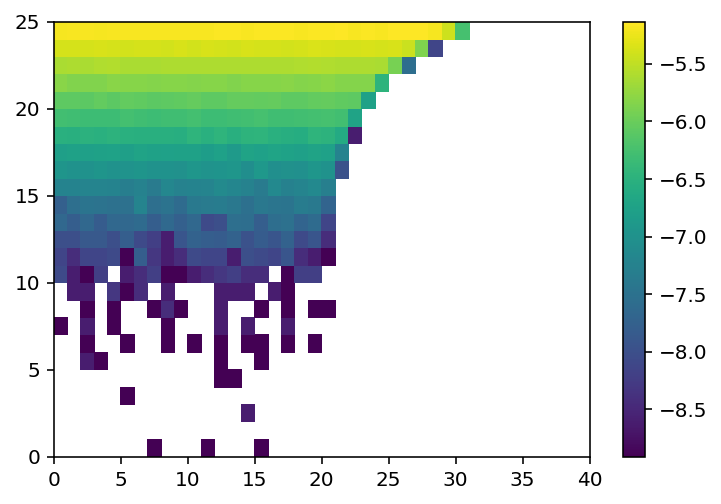

In [5]:
pl.pcolor(np.log10(pcdict['DR']));pl.colorbar()


In [111]:
!ls  /global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/QSO_N_CLUSTERING_wcomp-All-logrp-pi-DD.dat

/global/cfs/cdirs/desi/users/shadaba/sv3/XI/PairCount/QSO_N_CLUSTERING_wcomp-All-logrp-pi-DD.dat


In [9]:
#!cat /global/cfs/cdirs/desi/users/shadaba/sv3/XI/XI2D/BGS_ANY_N_CLUSTERING_wcomp-logrp-pi-NJN-48.txt

In [10]:
215*33*25

177375